# 目的
- 重量分布をplotする
- 特定の日付の重量を色分けする

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

import ChocoUtils as cu

load data

In [2]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0)")
print(data.shape)

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste in (0);
Shape of MeasurementData(record_num, n_columns) : (273, 14)
(273, 14)


plot

In [3]:
# 仕様の重量
spec = {0:28.0, 1:25.0, 4:22.0, 7:26.0, 10:22.0}
taste_name = {0:"peanut", 1:"strawberry", 4:"ama-zake", 7:"pachi-pachi", 10:"pineapple"}

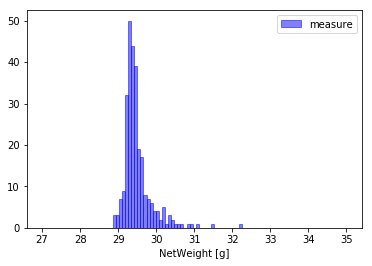

In [23]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1, 1)

bins = np.linspace(27., 35., 100)
ret = ax.hist(data['net_weight'], 
               bins=bins, color="#0000FF", alpha=0.5, edgecolor="#0000FF", 
               label='measure')
ax.set_xlabel("NetWeight [g]")
ax.legend()


該当の日付のみ色分けしてplot

In [20]:
data['measure_date_t'] = pd.to_datetime(data['measure_date'], format='%Y-%m-%d')

In [21]:
w_list = [data.loc[data['measure_date_t']<pd.to_datetime('2018-11-07')]['net_weight'], 
          data.loc[data['measure_date_t']>=pd.to_datetime('2018-11-07')]['net_weight']]

/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


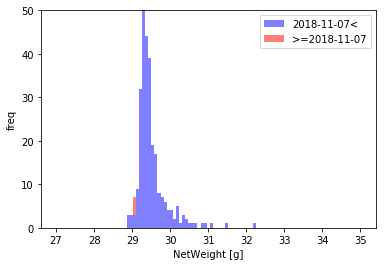

In [22]:
fig = plt.figure(figsize=(6,4))
ax = fig.subplots(1, 1)

ax.hist(w_list, bins=bins, color=['#0000FF', '#FF0000'], alpha=0.5, 
        label=['2018-11-07<', '>=2018-11-07'], 
        histtype='bar', stacked=True)
ax.set_xlabel('NetWeight [g]')
ax.set_ylabel('freq')
ax.legend()